# **Problem statement**


Singlife has observed a concerning trend in the customer journey: potential policyholders are expressing hesitation and eventual disengagement during the insurance acquisition process. To address this, Singlife seeks to leverage its dataset.

 The objective is to derive actionable insights from this data to enhance the customer experience. The challenge is to dissect the dataset to uncover the critical touchpoints that contribute to customer drop-off and identify opportunities to streamline the application process and personalise communication. The ultimate goal is to predict customer satisfaction and conversion rates, thereby bolstering Singlife's market position.


In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [5]:
filepath = "./data/catB_train.parquet" 

client_df = pd.read_parquet(filepath)
client_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17992 entries, 19550 to 15795
Columns: 304 entries, clntnum to f_purchase_lh
dtypes: float64(44), int64(46), object(214)
memory usage: 41.9+ MB


## Part 1: Data Preprocessing 

In [6]:
nan_counts = client_df.isna().sum()
columns_with_na = nan_counts[nan_counts > 0]
pd.set_option('display.max_rows', None)
print(columns_with_na)

race_desc                             3996
ctrycode_desc                           20
cltsex_fix                              23
flg_substandard                       1014
flg_is_borderline_standard            1014
flg_is_revised_term                   1014
flg_is_rental_flat                    1014
flg_has_health_claim                  1014
flg_has_life_claim                    1014
flg_gi_claim                          1014
flg_is_proposal                       1014
flg_with_preauthorisation             1014
flg_is_returned_mail                  1014
is_consent_to_mail                    1014
is_consent_to_email                   1014
is_consent_to_call                    1014
is_consent_to_sms                     1014
is_valid_dm                           1014
is_valid_email                        1014
is_housewife_retiree                  1014
is_sg_pr                              1014
is_class_1_2                          1014
is_dependent_in_at_least_1_policy     1014
f_ever_decl

In [23]:
general_client_info = client_df.loc[:,'race_desc': 'cltsex_fix']
risk_status_info = client_df.loc[:,'flg_substandard':'flg_is_returned_mail']
communication_info = client_df.loc[:,'is_consent_to_mail':'is_valid_email']
demographic_household_info = client_df.loc[:,'is_housewife_retiree':'annual_income_est']
policy_info = client_df.loc[:,"n_months_last_bought_products":"tot_cancel_pols"]
ip_metric_info = client_df.loc[:,"ape_gi_42e115":"prempaid_gi"]
purchase_lapse_history_info_1 = client_df.loc[:,"lapse_ape_ltc_1280bf":"lapse_ape_32c74c"]
purchase_lapse_history_info_2 = client_df.loc[:,"n_months_since_lapse_ltc_1280bf":"n_months_last_bought_32c74c"]
other_metrics = client_df.loc[:,"f_elx":"flg_gi_claim_42e115_ever"]
target = client_df["f_purchase_lh"]

In [24]:
general_client_info['race_desc'] = general_client_info['race_desc'].fillna(method = "ffill")
general_client_info['race_desc'] = general_client_info['race_desc'].astype('category')

encoding = pd.get_dummies(general_client_info['race_desc'], prefix='race',drop_first=True)

general_client_info = pd.concat([general_client_info,encoding],axis = 1)

general_client_info['ctrycode_desc'] =  general_client_info['ctrycode_desc'].replace("Unknown Country Code", general_client_info['ctrycode_desc'].mode().iloc[0])
general_client_info['ctrycode_desc'] =  general_client_info['ctrycode_desc'].replace("Not Applicable", general_client_info['ctrycode_desc'].mode().iloc[0])
general_client_info['ctrycode_desc'] = general_client_info['ctrycode_desc'].fillna(value = general_client_info['ctrycode_desc'].mode().iloc[0])
general_client_info['ctrycode_desc'] = general_client_info['ctrycode_desc'].map(lambda x: 'Others' if x not in ['Singapore','Malaysia'] else x)
general_client_info['ctrycode_desc'] = general_client_info['ctrycode_desc'].astype('category')

encoding = pd.get_dummies(general_client_info['ctrycode_desc'], prefix='ctry',drop_first=True)
general_client_info = pd.concat([general_client_info,encoding],axis = 1)

general_client_info['clttype'] = general_client_info['clttype'].map(lambda x: 1 if x == "P" else 0)

general_client_info['stat_flag'] = general_client_info['stat_flag'].map(lambda x: 1 if x == "ACTIVE" else 0)

general_client_info['min_occ_date'] = general_client_info['min_occ_date'].replace({"None":np.nan})
general_client_info['min_occ_date'] = pd.to_datetime(general_client_info['min_occ_date'],errors = "coerce")
general_client_info['min_occ_date'] = general_client_info['min_occ_date'].interpolate(method = "pad")
general_client_info['time_since_inception'] = (datetime.now() - general_client_info['min_occ_date'])
general_client_info['time_since_inception'] = round((general_client_info['time_since_inception'].dt.days)/365.25)
general_client_info = general_client_info.drop(['min_occ_date'],axis = 1)

general_client_info['cltdob_fix'] = general_client_info['cltdob_fix'].replace({"None":np.nan})
general_client_info['cltdob_fix'] = pd.to_datetime(general_client_info['cltdob_fix'],errors = "coerce")
general_client_info['cltdob_fix'] = general_client_info['cltdob_fix'].interpolate(method = "pad")
general_client_info['age'] = (datetime.now() - general_client_info['cltdob_fix'])
general_client_info['age'] = round((general_client_info['age'].dt.days)/365.25)
general_client_info = general_client_info.drop(['cltdob_fix'],axis = 1)

general_client_info["cltsex_fix"] = general_client_info["cltsex_fix"].fillna(method = "ffill")
general_client_info["cltsex_fix"] = general_client_info["cltsex_fix"].map(lambda x: 1 if x == "Male" else 0)
###################################################################################################################################
for feature in risk_status_info:
  risk_status_info[feature] = risk_status_info[feature].fillna(value = risk_status_info[feature].mode().iloc[0])
###################################################################################################################################
# filling NA values with 0
communication_info = communication_info.loc[:,'is_consent_to_mail':'is_valid_email'].fillna(0)
demographic_household_info = demographic_household_info.loc[:,'is_housewife_retiree':'annual_income_est'].fillna(9999)
demographic_household_info["annual_income_est"].value_counts()
# one-hot encoding for the categorical data
encoding = pd.get_dummies(demographic_household_info['annual_income_est'], prefix='inc',drop_first=True)
demographic_household_info = demographic_household_info.drop(['annual_income_est'],axis = 1)
demographic_household_info = pd.concat([demographic_household_info,encoding],axis = 1)
###################################################################################################################################
# dropping hh_size as it is a "duplicate" of hh_size_est
demographic_household_info = demographic_household_info.drop(['hh_size'],axis = 1)
encoding = pd.get_dummies(demographic_household_info['hh_size_est'], prefix='hh_size',drop_first=True)
demographic_household_info = demographic_household_info.drop(['hh_size_est'],axis = 1)
demographic_household_info = pd.concat([demographic_household_info,encoding],axis = 1)
###################################################################################################################################
policy_info['recency_lapse'] = policy_info['recency_lapse'].fillna(0)
policy_info['recency_cancel'] = policy_info['recency_cancel'].fillna(0)
policy_info['tot_cancel_pols'] = policy_info['tot_cancel_pols'].fillna(0)
###################################################################################################################################
other_metrics = client_df.loc[:,"f_elx":"flg_gi_claim_42e115_ever"].fillna(0)
purchase_lapse_history_info_1 = client_df.loc[:,"lapse_ape_ltc_1280bf":"lapse_ape_32c74c"].fillna(0)
purchase_lapse_history_info_2 = client_df.loc[:,"n_months_since_lapse_ltc_1280bf":"n_months_last_bought_32c74c"].fillna(9999)
###################################################################################################################################
client_df_cleaned = pd.concat([general_client_info,
                               risk_status_info,
                               communication_info,
                               demographic_household_info,
                               policy_info,
                               ip_metric_info,
                               purchase_lapse_history_info_1,
                               purchase_lapse_history_info_2,
                               other_metrics],
                              axis =1 )

# Data Visualization

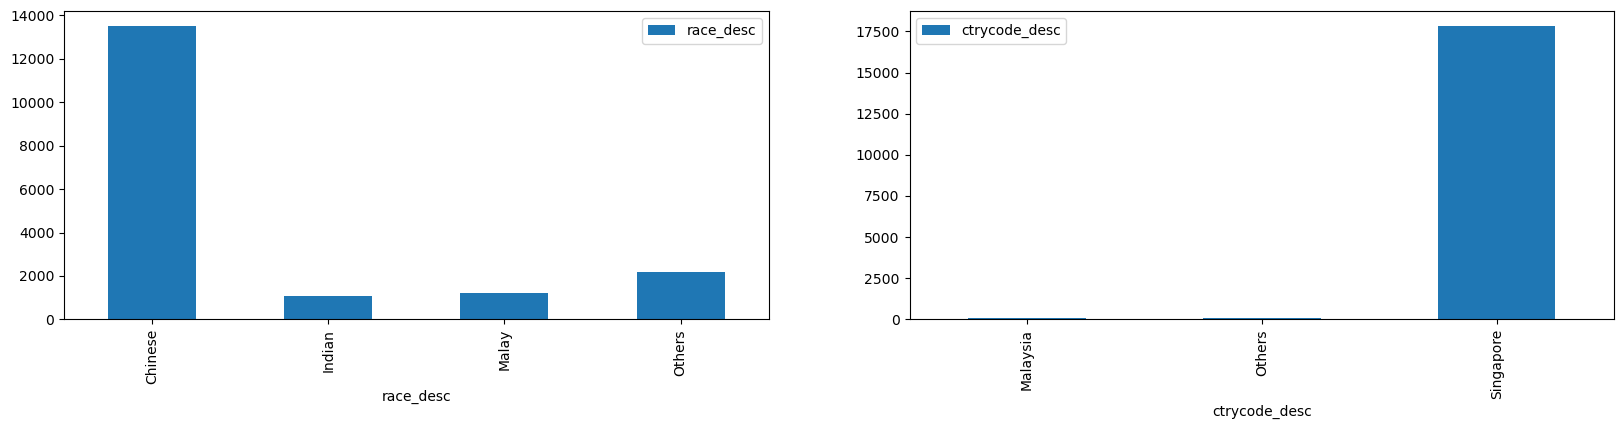

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,4))
pd.DataFrame(general_client_info.groupby(['race_desc'])['race_desc'].count()).plot(kind = 'bar',ax = ax1)
pd.DataFrame(general_client_info.groupby(['ctrycode_desc'])['ctrycode_desc'].count()).plot(kind = 'bar',ax = ax2)
general_client_info = general_client_info.drop(['race_desc'],axis = 1)
general_client_info = general_client_info.drop(['ctrycode_desc'],axis = 1)

<Axes: >

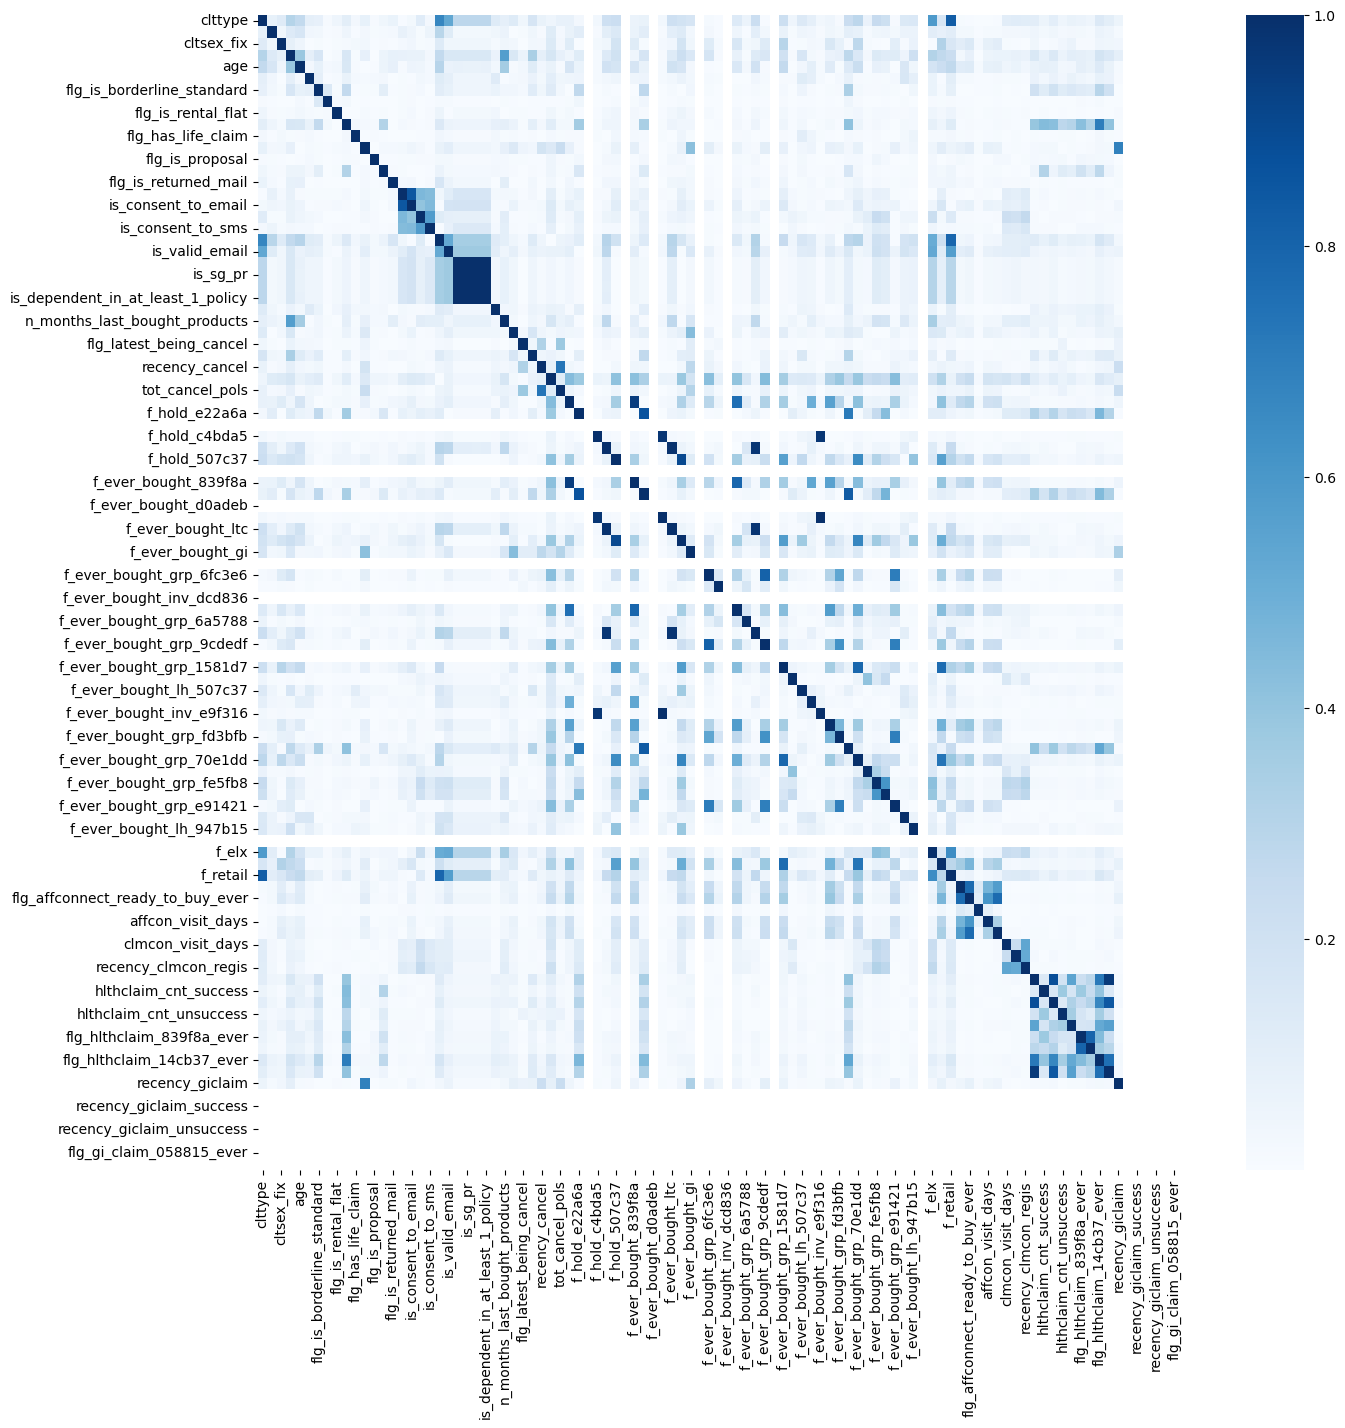

In [9]:
# Heatmap
numerical_cols = client_df_cleaned.select_dtypes(include=np.number)
correlation_matrixx = numerical_cols.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(abs(correlation_matrixx), cmap='Blues')

According to the correlation heatmap plotted above, we can conclude that the target variable has very low levels of correlation with all the ...
This observation highlights the difficulty in determining the individual features' significance within our model.

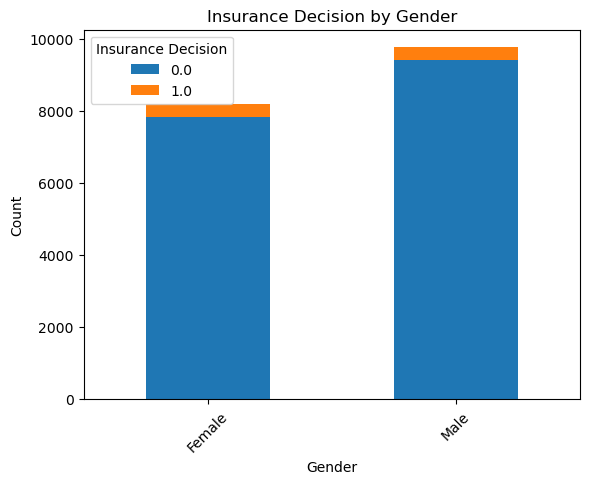

In [10]:
new = client_df['f_purchase_lh'].fillna(0)

grouped = client_df.groupby(['cltsex_fix', new]).size().unstack(fill_value=0)

# Plotting the grouped bar chart
grouped.plot(kind='bar', stacked=True)

plt.title('Insurance Decision by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Insurance Decision', loc='upper left')
plt.show()

According to the bar graph that is plotted above, we can conclude that the target variable has very low levels of correlation with gender.

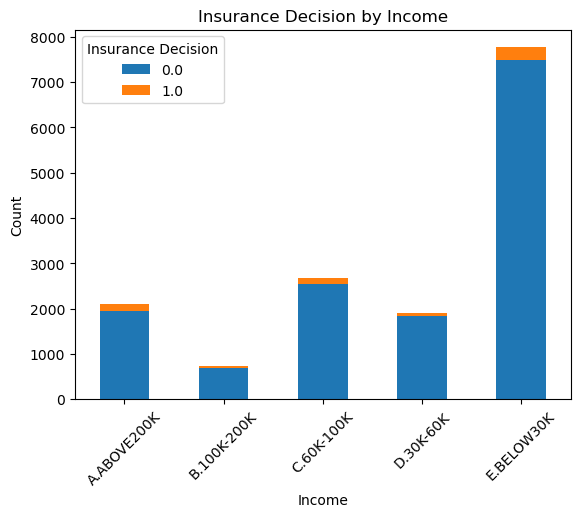

In [11]:
new = client_df['f_purchase_lh'].fillna(0)

grouped = client_df.groupby(['annual_income_est', new]).size().unstack(fill_value=0)

# Plotting the grouped bar chart
grouped.plot(kind='bar', stacked=True)

plt.title('Insurance Decision by Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Insurance Decision', loc='upper left')
plt.show()

According to the bar graph that is plotted above, we can conclude that the target variable has very low levels of correlation with income level.

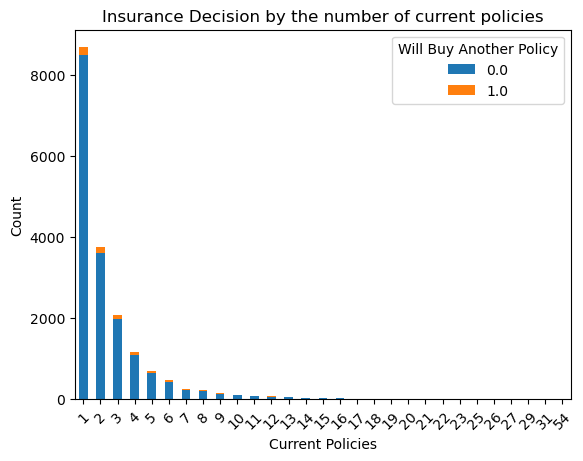

In [12]:
new = client_df['f_purchase_lh'].fillna(0)
bins = [0, 1, 2, 3, 4, 5]

# Create a new column with the bin labels
client_df['Policy_Bins'] = pd.cut(client_df['tot_inforce_pols'], bins)

# Group by Policy_Bins and Will_Buy_Another, then count occurrences
grouped = client_df.groupby(['tot_inforce_pols', new]).size().unstack()

# Plot stacked bar graph
grouped.plot(kind='bar', stacked=True)
plt.title('Insurance Decision by the number of current policies')
plt.xlabel('Current Policies')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Will Buy Another Policy')
plt.show()

According to the bar graph that is plotted above, we can conclude that the target variable has moderate levels of correlation with the number of insurance policies that they currently have.

In [13]:
object_columns= client_df_cleaned.select_dtypes(include=['object'])
for column in object_columns.columns:
    client_df_cleaned[column] = pd.to_numeric(client_df_cleaned[column], errors='coerce')


In [14]:
## target column
target = client_df["f_purchase_lh"].fillna(0)

# Model Building 

In [15]:
x_train, x_val, y_train, y_val = train_test_split(client_df_cleaned, target, test_size=0.2, random_state=0)

In [16]:
smote = SMOTE(random_state=42) # Create SMOTE object
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [17]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(x_train_smote, y_train_smote)
y_pred = nb_classifier.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display the classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.28
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.25      0.40      3473
         1.0       0.04      0.89      0.08       126

    accuracy                           0.28      3599
   macro avg       0.51      0.57      0.24      3599
weighted avg       0.95      0.28      0.39      3599



In [18]:
xgb = xgboost.XGBClassifier()
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}
xgb_random=RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
xgb_random.fit(x_train_smote,y_train_smote)
xgb_random.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.15,
 'gamma': 0.3,
 'colsample_bytree': 0.4}

In [21]:
xgb_tuned=xgboost.XGBClassifier(min_child_weight= 5,max_depth= 12,learning_rate= 0.15,gamma= 0.3,colsample_bytree= 0.4)
xgb_tuned.fit(x_train_smote,y_train_smote)
ypredxgb=xgb_tuned.predict(x_val)
print(classification_report(y_val,ypredxgb))
cm = metrics.confusion_matrix(y_val, ypredxgb)
print(cm)

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      3473
         1.0       0.55      0.17      0.26       126

    accuracy                           0.97      3599
   macro avg       0.76      0.58      0.62      3599
weighted avg       0.96      0.97      0.96      3599

[[3456   17]
 [ 105   21]]


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [28]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    general_client_info = hidden_data.loc[:,'race_desc': 'cltsex_fix']
    risk_status_info = hidden_data.loc[:,'flg_substandard':'flg_is_returned_mail']
    communication_info = hidden_data.loc[:,'is_consent_to_mail':'is_valid_email']
    demographic_household_info = hidden_data.loc[:,'is_housewife_retiree':'annual_income_est']
    policy_info = hidden_data.loc[:,"n_months_last_bought_products":"tot_cancel_pols"]
    ip_metric_info = hidden_data.loc[:,"ape_gi_42e115":"prempaid_gi"]
    purchase_lapse_history_info_1 = hidden_data.loc[:,"lapse_ape_ltc_1280bf":"lapse_ape_32c74c"]
    purchase_lapse_history_info_2 = hidden_data.loc[:,"n_months_since_lapse_ltc_1280bf":"n_months_last_bought_32c74c"]
    other_metrics = hidden_data.loc[:,"f_elx":"flg_gi_claim_42e115_ever"]
    
    general_client_info['race_desc'] = general_client_info['race_desc'].fillna(method = "ffill")
    general_client_info['race_desc'] = general_client_info['race_desc'].astype('category')
    
    encoding = pd.get_dummies(general_client_info['race_desc'], prefix='race',drop_first=True)
    
    general_client_info = pd.concat([general_client_info,encoding],axis = 1)
    
    general_client_info['ctrycode_desc'] =  general_client_info['ctrycode_desc'].replace("Unknown Country Code", general_client_info['ctrycode_desc'].mode().iloc[0])
    general_client_info['ctrycode_desc'] =  general_client_info['ctrycode_desc'].replace("Not Applicable", general_client_info['ctrycode_desc'].mode().iloc[0])
    general_client_info['ctrycode_desc'] = general_client_info['ctrycode_desc'].fillna(value = general_client_info['ctrycode_desc'].mode().iloc[0])
    general_client_info['ctrycode_desc'] = general_client_info['ctrycode_desc'].map(lambda x: 'Others' if x not in ['Singapore','Malaysia'] else x)
    general_client_info['ctrycode_desc'] = general_client_info['ctrycode_desc'].astype('category')
    
    encoding = pd.get_dummies(general_client_info['ctrycode_desc'], prefix='ctry',drop_first=True)
    general_client_info = pd.concat([general_client_info,encoding],axis = 1)
    
    general_client_info['clttype'] = general_client_info['clttype'].map(lambda x: 1 if x == "P" else 0)
    
    general_client_info['stat_flag'] = general_client_info['stat_flag'].map(lambda x: 1 if x == "ACTIVE" else 0)
    
    general_client_info['min_occ_date'] = general_client_info['min_occ_date'].replace({"None":np.nan})
    general_client_info['min_occ_date'] = pd.to_datetime(general_client_info['min_occ_date'],errors = "coerce")
    general_client_info['min_occ_date'] = general_client_info['min_occ_date'].interpolate(method = "pad")
    general_client_info['time_since_inception'] = (datetime.now() - general_client_info['min_occ_date'])
    general_client_info['time_since_inception'] = round((general_client_info['time_since_inception'].dt.days)/365.25)
    general_client_info = general_client_info.drop(['min_occ_date'],axis = 1)
    
    general_client_info['cltdob_fix'] = general_client_info['cltdob_fix'].replace({"None":np.nan})
    general_client_info['cltdob_fix'] = pd.to_datetime(general_client_info['cltdob_fix'],errors = "coerce")
    general_client_info['cltdob_fix'] = general_client_info['cltdob_fix'].interpolate(method = "pad")
    general_client_info['age'] = (datetime.now() - general_client_info['cltdob_fix'])
    general_client_info['age'] = round((general_client_info['age'].dt.days)/365.25)
    general_client_info = general_client_info.drop(['cltdob_fix'],axis = 1)
    
    general_client_info["cltsex_fix"] = general_client_info["cltsex_fix"].fillna(method = "ffill")
    general_client_info["cltsex_fix"] = general_client_info["cltsex_fix"].map(lambda x: 1 if x == "Male" else 0)
    ###################################################################################################################################
    for feature in risk_status_info:
      risk_status_info[feature] = risk_status_info[feature].fillna(value = risk_status_info[feature].mode().iloc[0])
    ###################################################################################################################################
    # filling NA values with 0
    communication_info = communication_info.loc[:,'is_consent_to_mail':'is_valid_email'].fillna(0)
    demographic_household_info = demographic_household_info.loc[:,'is_housewife_retiree':'annual_income_est'].fillna(9999)
    demographic_household_info["annual_income_est"].value_counts()
    # one-hot encoding for the categorical data
    encoding = pd.get_dummies(demographic_household_info['annual_income_est'], prefix='inc',drop_first=True)
    demographic_household_info = demographic_household_info.drop(['annual_income_est'],axis = 1)
    demographic_household_info = pd.concat([demographic_household_info,encoding],axis = 1)
    ###################################################################################################################################
    # dropping hh_size as it is a "duplicate" of hh_size_est
    demographic_household_info = demographic_household_info.drop(['hh_size'],axis = 1)
    encoding = pd.get_dummies(demographic_household_info['hh_size_est'], prefix='hh_size',drop_first=True)
    demographic_household_info = demographic_household_info.drop(['hh_size_est'],axis = 1)
    demographic_household_info = pd.concat([demographic_household_info,encoding],axis = 1)
    ###################################################################################################################################
    policy_info['recency_lapse'] = policy_info['recency_lapse'].fillna(0)
    policy_info['recency_cancel'] = policy_info['recency_cancel'].fillna(0)
    policy_info['tot_cancel_pols'] = policy_info['tot_cancel_pols'].fillna(0)
    ###################################################################################################################################
    other_metrics = client_df.loc[:,"f_elx":"flg_gi_claim_42e115_ever"].fillna(0)
    purchase_lapse_history_info_1 = client_df.loc[:,"lapse_ape_ltc_1280bf":"lapse_ape_32c74c"].fillna(0)
    purchase_lapse_history_info_2 = client_df.loc[:,"n_months_since_lapse_ltc_1280bf":"n_months_last_bought_32c74c"].fillna(9999)
    ###################################################################################################################################
    client_df_cleaned = pd.concat([general_client_info,
                                   risk_status_info,
                                   communication_info,
                                   demographic_household_info,
                                   policy_info,
                                   ip_metric_info,
                                   purchase_lapse_history_info_1,
                                   purchase_lapse_history_info_2,
                                   other_metrics],
                                  axis =1 )

    result = [] 
    result = xgb_tuned.predict(client_df_cleaned)
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!